# <center> Deep Learning Project</center>
## <center>Spooky Authors Identification</center>
### <center>Historical Embedding Experiment</center>
#### <center>Score on Kaggle: 0.36 log loss</center>


---


*   Eduardo Brendao (MLDM)
*   Mohammad Poul Doust (MLDM)



# Preprocessing

In [0]:
# Preprocessing
def add_puctuation_and_n_grams(df, n_gram_max=2):
    def add_ngram(q, n_gram_max):
            ngrams = []
            for n in range(2, n_gram_max+1):
                for w_index in range(len(q)-n+1):
                    ngrams.append('--'.join(q[w_index:w_index+n]))
            return q + ngrams
    
    def punctuation_to_words(text):
      text = text.replace("' ", " ' ")
      signs = set(',.:;"?!')
      prods = set(text) & signs
      if not prods:
          return text

      for sign in prods:
          text = text.replace(sign, ' {} '.format(sign) )
      return text

    docs = []

    if isinstance(df, pd.DataFrame):
      for doc in df.text:
        doc = punctuation_to_words(doc).split()
        docs.append(' '.join(add_ngram(doc, n_gram_max)))
    else:
      for doc in df:
        doc = punctuation_to_words(doc).split()
        docs.append(' '.join(add_ngram(doc, n_gram_max)))
   
    return docs

In [0]:
#imports
import pandas as pd
import numpy as np
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import NMF, LatentDirichletAllocation
from math import floor
import pickle
from sklearn import preprocessing
from sklearn.pipeline import make_pipeline

#keras
from keras.initializers import Constant
from keras.models import Sequential, Model
from keras.layers import Dense, Embedding, GlobalAveragePooling1D, LSTM, Dropout,BatchNormalization, Input, Conv1D, MaxPooling1D, Flatten
import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings('ignore')


Using TensorFlow backend.


# HistWords scikit learn estimator

In [0]:
# An estimator for use with ELI5 plus a bonus function because that's how I got it to work

from sklearn.base import BaseEstimator, TransformerMixin

class HistoricalClassifier(BaseEstimator, TransformerMixin):
  '''Wrapper class for keras text classification models that takes raw text as input.'''
  
  def __init__(self, input_dim, min_count =2, input_length=256, n_classes=3, epochs=25, batch_size=16, number_of_n_grams =2, embedding_dim =20, weights = None):
    self.emb_dim = embedding_dim
    self.input_dim = input_dim
    self.input_length = input_length
    self.n_classes = n_classes
    self.epochs = epochs
    self.bs = batch_size
    self.min_count = min_count
    self.model = self._get_model(weights)
    self.number_of_n_grams = number_of_n_grams
    self.tokenizer = None
    return self.model.summary()
    
  def _get_model(self, _weights = None):
    """This is fast text, as per https://arxiv.org/abs/1607.01759"""
    model = Sequential()
    if _weights is not None:
      model.add(Embedding(input_dim = self.input_dim,output_dim=self.emb_dim, weights = [_weights], trainable = True))
      # model.add(Embedding(input_dim = self.input_dim,output_dim=self.emb_dim, embeddings_initializer=Constant(weights)))
      print('weights initialized')
    else:
      model.add(Embedding(input_dim = self.input_dim,output_dim=self.emb_dim))
    model.add(GlobalAveragePooling1D())
    model.add(Dense(self.n_classes, activation='softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer="adam",
                  metrics=['accuracy']) 
    return model

  def _get_tokenizer(self, X):
    texts = self._preprocess(X)
    tokenizer = Tokenizer(lower=True, filters='')
    tokenizer.fit_on_texts(texts)
    return tokenizer


  
  def _get_sequences(self, X):
    """Change lower=False not to match case"""
    texts = self._preprocess(X)
    tokenizer = Tokenizer(lower=True, filters='')
    tokenizer.fit_on_texts(texts)
    num_words = sum([1 for _, v in tokenizer.word_counts.items() if v >= self.min_count])
    
    tokenizer = Tokenizer(num_words=num_words, lower=True, filters='')
    tokenizer.fit_on_texts(texts)
    texts = tokenizer.texts_to_sequences(texts)
    texts = pad_sequences(sequences = texts, maxlen=self.input_length)
    self.tokenizer =tokenizer 
    return texts
  
  def _preprocess(self, texts):
    return add_puctuation_and_n_grams(texts, n_gram_max=self.number_of_n_grams)
  
  def fit(self, X, y):
    '''Fit the vocabulary and the model.
       :params: X: list of texts. y: labels.
    '''
    docs = self._get_sequences(X)
    x_train, x_test, y_train, y_test = train_test_split(docs, y, test_size=0.1)

    self.model.fit(x_train, y_train,
                 batch_size=self.bs,
                 validation_data=(x_test, y_test),
                 epochs=self.epochs,
                 callbacks=[EarlyStopping(patience=2, monitor='val_loss')])

  def predict_proba(self, X, y=None):
    seqs = self._get_sequences(self._preprocess(X))
    return self.model.predict(seqs)
  
  def predict(self, X, y=None):
    return np.argmax(self.predict_proba(X), axis=1)
  
  def score(self, X, y):
    y_pred = self.predict(X)
    return accuracy_score(np.argmax(y, axis=1), y_pred)

def get_input_dimension(X, min_count=2, maxlen=256):
  """ Before creating a model, input dimension changes cuz we remove low freq words (lower than min_count)"""
  docs = add_puctuation_and_n_grams(X, n_gram_max=2)

  tokenizer = Tokenizer(lower=False, filters='')
  tokenizer.fit_on_texts(docs)
  num_words = sum([1 for _, v in tokenizer.word_counts.items() if v >= min_count])

  tokenizer = Tokenizer(num_words=num_words, lower=False, filters='')
  tokenizer.fit_on_texts(docs)
  docs = tokenizer.texts_to_sequences(docs)
  
  docs = pad_sequences(sequences=docs, maxlen=maxlen)
  return np.max(docs) + 1

# Get Data
... and split to debug with ELI5. Submission would use the entire training set.

In [0]:
# get dataset from Kaggle -- feel free to use my API key :)
import os
os.environ['KAGGLE_USERNAME'] = "extremelydifficult" # username from the json file
os.environ['KAGGLE_KEY'] = "238120927f9705524c124fcbdb19b699" # key from the json file
!kaggle competitions download -c spooky-author-identification
!unzip train.zip
!unzip test.zip

  0% 0.00/29.4k [00:00<?, ?B/s]
100% 29.4k/29.4k [00:00<00:00, 26.4MB/s]
  0% 0.00/1.26M [00:00<?, ?B/s]
100% 1.26M/1.26M [00:00<00:00, 84.8MB/s]
  0% 0.00/538k [00:00<?, ?B/s]
100% 538k/538k [00:00<00:00, 177MB/s]
Archive:  train.zip
  inflating: train.csv               
Archive:  test.zip
  inflating: test.csv                


In [0]:
import pandas as pd
import numpy as np
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

# get data from dataset
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
# sample = pd.read_csv('sample_submission.csv')
# Keras likes categorical
a2c = {'EAP': 0, 'HPL' : 1, 'MWS' : 2}
c2a = {value:key for key, value in a2c.items()}

authors = np.array([a2c[a] for a in train.author])
authors = to_categorical(authors)

# split data (JUST FOR DEBUGGING WITH ELI5 -- submission would use all training data)
text_train, text_valid, authors_train, authors_valid = train_test_split(train.text.values, authors, 
                                                   stratify=authors, 
                                                   test_size=0.1, shuffle=True)

# because it's easier than changing the loop below
x_train = pd.DataFrame(text_train, columns = ["text"])
x_test = pd.DataFrame(text_valid, columns = ["text"])

# Historical Embeddings

In [0]:
#historical all english
!wget 'http://snap.stanford.edu/historical_embeddings/eng-all_sgns.zip' -O "all_english.zip" 

--2019-12-27 15:54:17--  http://snap.stanford.edu/historical_embeddings/eng-all_sgns.zip
Resolving snap.stanford.edu (snap.stanford.edu)... 171.64.75.80
Connecting to snap.stanford.edu (snap.stanford.edu)|171.64.75.80|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1686718098 (1.6G) [application/zip]
Saving to: ‘all_english.zip’

all_english.zip     100%[===================>]   1.57G   109MB/s    in 15s     

2019-12-27 15:54:32 (105 MB/s) - ‘all_english.zip’ saved [1686718098/1686718098]



In [0]:
!unzip all_english.zip -d all_english

Archive:  all_english.zip
   creating: all_english/sgns/
  inflating: all_english/sgns/1860-vocab.pkl  
  inflating: all_english/sgns/1850-w.npy  
  inflating: all_english/sgns/1900-vocab.pkl  
  inflating: all_english/sgns/1930-w.npy  
  inflating: all_english/sgns/1880-w.npy  
  inflating: all_english/sgns/1870-w.npy  
  inflating: all_english/sgns/1910-w.npy  
  inflating: all_english/sgns/1970-vocab.pkl  
  inflating: all_english/sgns/1810-vocab.pkl  
  inflating: all_english/sgns/1970-w.npy  
  inflating: all_english/sgns/1810-w.npy  
  inflating: all_english/sgns/1920-vocab.pkl  
  inflating: all_english/sgns/1840-vocab.pkl  
  inflating: all_english/sgns/1990-vocab.pkl  
  inflating: all_english/sgns/1950-w.npy  
  inflating: all_english/sgns/1880-vocab.pkl  
  inflating: all_english/sgns/1980-w.npy  
  inflating: all_english/sgns/1830-w.npy  
  inflating: all_english/sgns/1830-vocab.pkl  
  inflating: all_english/sgns/1950-vocab.pkl  
  inflating: all_english/sgns/1890-vocab.pk

In [0]:
embeddings_index = {}
coefs = np.load('/content/all_english/sgns/1990-w.npy')
words = pickle.load( open( "/content/all_english/sgns/1990-vocab.pkl", "rb" ) )
embedding_index = {words[i] : coefs[i] for i in range(len(words))}

In [0]:
EMBEDDING_DIM = 300
in_dim = get_input_dimension(x_train)

In [0]:
# word_index = text_model._get_tokenizer(x_train).word_index
texts = add_puctuation_and_n_grams(x_train,n_gram_max=2)
tokenizer = Tokenizer(lower=True, filters='')
tokenizer.fit_on_texts(texts)
word_index = tokenizer.word_index

MAX_NUM_WORDS = 100000
num_words = in_dim
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word_index.items():
    if i >= MAX_NUM_WORDS:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [0]:
text_model = HistoricalClassifier(input_dim = in_dim, n_classes=3, weights= embedding_matrix, embedding_dim=300)










weights initialized


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 300)         21020100  
_________________________________________________________________
global_average_pooling1d_1 ( (None, 300)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 903       
Total params: 21,021,003
Trainable params: 21,021,003
Non-trainable params: 0
_________________________________________________________________


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 15858 samples, validate on 1763 samples
Epoch 1/25
15858/15858 [==============================] - 12s 738us/step - loss: 0.8978 - acc: 0.5935 - val_loss: 0.6468 - val_acc: 0.7567
Epoch 2/25
15858/15858 [==============================] - 10s 601us/step - loss: 0.4354 - acc: 0.8576 - val_loss: 0.4631 - val_acc: 0.8174
Epoch 3/25
15858/15858 [==============================] - 10s 602us/step - loss: 0.2304 - acc: 0.9344 - val_loss: 0.4035 - val_acc: 0.8406
Epoch 4/25
15858/15858 [==============================] - 9s 599us/step - loss: 0.1295 - acc: 0.9689 - val_loss: 0.3787 - val_acc: 0.8457
Epoch 5/25
15858/15858 [==============================] - 9s 597us/step - loss: 0.0767 - acc: 0.9833 - val_loss: 0.3734 - val_acc: 0.8440
Epoch 6/25
15858/15858 [==============================] - 10s 599us/step - loss: 0.0458 - acc: 0.9912 - val_loss: 0.3784 - val_acc: 0.8455


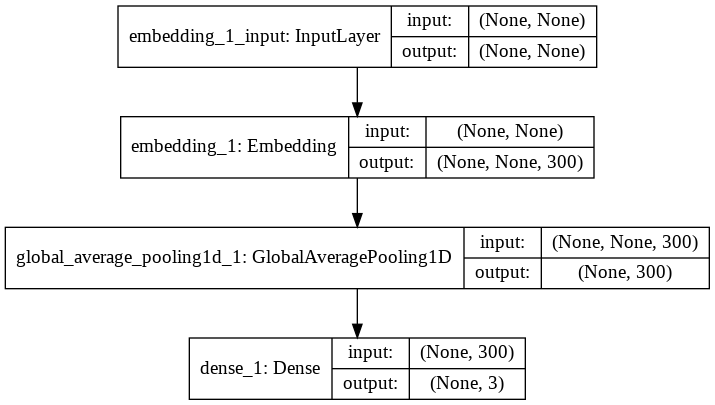

In [0]:
from keras.utils.vis_utils import plot_model

text_model.fit(x_train, authors_train)
plot_model(text_model.model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

**Private Score: 0.36**